# 1. Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import math
import time
import itertools
import datetime
from datetime import datetime
import seaborn as sns

import string
from wordcloud import STOPWORDS

from scipy.stats import skew, boxcox
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

# xgboost
import xgboost as xgb

#Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 2. Configuration

In [2]:
output_featimp = 'feat_xgb_v17_regtweedie.csv'
output_sub     = 'sub_xgb_v17_regtweedie.csv'
output_oof     = 'oof_xgb_v17_regtweedie.csv'

ID = 'tweet_id'
TARGET = 'engagement_count'
NFOLDS = 5
SEED = 2023
NROWS = None
DATA_DIR = "../input"

TRAIN_FILE = "{0}/expert_training.csv".format(DATA_DIR)
TEST_FILE = "{0}/expert_testing.csv".format(DATA_DIR)
SUBMISSION_FILE = "{0}/expert_samplesubmission.csv".format(DATA_DIR)

params = {
    'seed': 0,
    'booster': 'gbtree', # gbtree, gblinear or dart
    'objective': 'reg:tweedie', # count:poisson, reg:linear, reg:squarederror, reg:squaredlogerror, reg:absoluteerror, reg:gamma, reg:tweedie
    'learning_rate': 0.01, # default=0.3
    'max_depth': 12, # default=6
    'min_child_weight': 10, # default=1
    'subsample': 0.9, # default=1
    'colsample_bytree': 0.8, # default=1
#     'gamma': 0, # default=0
#     'lambda': 1, # default=1
#     'alpha': 0, # default=0
    }

# 3. Functions

In [3]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def xg_eval_rmse(yhat, dtrain):
    y = dtrain.get_label()
    return 'rmse', np.sqrt(((yhat - y) ** 2).mean())

# 4. Data

In [4]:
# read data
train = pd.read_csv(TRAIN_FILE, nrows=NROWS)
test = pd.read_csv(TEST_FILE, nrows=NROWS)

# fill test target
test[TARGET] = 0

# name + text
train['name_time_text'] = train['screen_name'] + " " + train['created_at'] + " "  + train['full_text']
test['name_time_text']  = test['screen_name']  + " " + test['created_at']  + " "  + test['full_text']

# drop duplicates (the first one will be kept)
train_df = train.drop_duplicates(subset=['name_time_text'])
test_df  = test.drop_duplicates(subset=['name_time_text'])

# train test indicator
train_df['train_test'] = 'train'
test_df['train_test']  = 'test'

# concat
train_test_df = pd.concat([train_df, test_df], axis=0)

# flag for duplicated one (last one(test) will have "True")
train_test_df['in_train'] = train_test_df['name_time_text'].duplicated()

# add "in_train" flag to original test data
in_train_df = train_test_df.loc[train_test_df['in_train']]
in_train_df = in_train_df[['name_time_text','in_train']]
test = test.merge(in_train_df, on='name_time_text', how='left')
test['in_train'] = test['in_train'].fillna(False)

# set aside train_test_df after removing duplicates (the first one(train) will be kept). It will be used for feature engineering
train_test_df = train_test_df[~train_test_df['in_train']]

# separate test "in train' and 'not in train'
test_in_train = test[test['in_train']]
test_not_in_train = test[~test['in_train']]

# get target values from train_df
test_in_train = test_in_train.drop([TARGET], axis=1)
test_in_train = test_in_train.merge(train_df[['name_time_text',TARGET]], on='name_time_text', how='left')

# get # of rows
ntrain = train_df.shape[0]
ntest = test_not_in_train.shape[0]

# drop_index
test_not_in_train = test_not_in_train.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

# get id and target
id_train = train_df[ID]
id_test = test_not_in_train[ID]
y_train = train_df[TARGET]

# make them have the same columns
test_not_in_train = test_not_in_train.drop(['in_train'], axis=1)
test_not_in_train['train_test'] = 'test'

# concatenate train and test
train_test = pd.concat([train_df, test_not_in_train]).reset_index(drop=True)

C:\Users\kkudo\AppData\Local\Temp\ipykernel_27632\2301700253.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['train_test'] = 'train'
C:\Users\kkudo\AppData\Local\Temp\ipykernel_27632\2301700253.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['train_test']  = 'test'


# 5. Preprocessing

##### train_test:   train does not have duplicates, but test has duplicates
##### train_test_df:it does not have duplicates. It will be used for feature engineering

In [5]:
names = ['songmyeongho1',
 'web3_inu',
 'ethereum',
 'NFTcollector00',
 'web3',
 'PulsechainCom',
 'Bitcoin',
 'magicianpromos',
 'cryptoBILLnfts',
 'cryptopunksnfts',
 'cryptoworld_gg',
 'russnft',
 'Crypto_Inside_',
 'DeGodsNFT',
 'BabyDogeNFTs',
 'CryptoCapo_',
 'MrsunNFT',
 'kris',
 'AnuelNFT',
 'cryptocom',
 'NftCryptosArt']

# train_test.query(f'screen_name in {names}')
train_test.loc[train_test['screen_name'].isin(names),'highprofile'] = 1
train_test['highprofile'] = train_test['highprofile'].fillna(0)
train_test['highprofile'] = train_test['highprofile'].astype(int)

train_test_df.loc[train_test_df['screen_name'].isin(names),'highprofile'] = 1
train_test_df['highprofile'] = train_test_df['highprofile'].fillna(0)
train_test_df['highprofile'] = train_test_df['highprofile'].astype(int)

In [6]:
X = pd.DataFrame()

# screen_name
X['highprofile'] = train_test['highprofile']
# X['highprofile'] = X['highprofile'].astype(int)

## created at
# convert 'created_at' from object to datetime
train_test['created_at'] = pd.to_datetime(train_test['created_at'])
train_test['dayname'] = train_test['created_at'].dt.strftime('%A')
train_test['date'] = pd.to_datetime(train_test['created_at']).dt.date
train_test['yrmonth'] = (pd.to_datetime(train_test['created_at']).dt.year-2013)*12+pd.to_datetime(train_test['created_at']).dt.month
train_test['year'] = pd.to_datetime(train_test['created_at']).dt.year

train_test_df['created_at'] = pd.to_datetime(train_test_df['created_at'])
train_test_df['dayname'] = train_test_df['created_at'].dt.strftime('%A')
train_test_df['date'] = pd.to_datetime(train_test_df['created_at']).dt.date
train_test_df['yrmonth'] = (pd.to_datetime(train_test_df['created_at']).dt.year-2013)*12+pd.to_datetime(train_test_df['created_at']).dt.month
train_test_df['year'] = pd.to_datetime(train_test_df['created_at']).dt.year


# ymd
X['created_at_year'] = pd.to_datetime(train_test['created_at']).dt.year
X['created_at_month'] = pd.to_datetime(train_test['created_at']).dt.month
X['created_at_yrmonth'] = (pd.to_datetime(train_test['created_at']).dt.year-2013)*12+pd.to_datetime(train_test['created_at']).dt.month

# day name
tmp = pd.get_dummies(train_test['dayname'], prefix='dayname', prefix_sep='_')
X = pd.concat([X, tmp], axis=1)

# le = LabelEncoder()
# X['dayname']= le.fit_transform(train_test['dayname'])


## full text
# count of words
X['count_words'] = train_test['full_text'].str.split().map(lambda x: len(x))

# count of characters
X['count_chars'] = train_test['full_text'].str.len()

# count of unique workds
X['unique_word_count'] = train_test['full_text'].apply(lambda x: len(set(str(x).split())))

# count of stop word
X['stop_word_count'] = train_test['full_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
X['url_count'] = train_test['full_text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
X['mean_word_length'] = train_test['full_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# punctuation_count
X['punctuation_count'] = train_test['full_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
X['hashtag_count'] = train_test['full_text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
X['mention_count'] = train_test['full_text'].apply(lambda x: len([c for c in str(x) if c == '@']))


## tweet frequency - for aggregation, make sure to use "train_test_df" (not "train_test")
# same day
tmp = train_test_df.groupby(['screen_name','date'])['full_text'].count().reset_index()
tmp = tmp.rename(columns={"full_text": "tweet_count_same_day"})
tmp.head()

train_test = train_test.merge(tmp, how='left', on=['screen_name','date'])
train_test['tweet_count_same_day'] = train_test['tweet_count_same_day'].fillna(0)
X['tweet_count_same_day'] = train_test['tweet_count_same_day']

# same month
tmp = train_test_df.groupby(['screen_name','yrmonth'])['full_text'].count().reset_index()
tmp = tmp.rename(columns={'full_text': 'tweet_count_same_month'})
tmp.head()

train_test = train_test.merge(tmp, how='left', on=['screen_name','yrmonth'])
train_test['tweet_count_same_month'] = train_test['tweet_count_same_month'].fillna(0)
X['tweet_count_same_month'] = train_test['tweet_count_same_month']

# same year
tmp = train_test_df.groupby(['screen_name','year'])['full_text'].count().reset_index()
tmp = tmp.rename(columns={'full_text': 'tweet_count_same_year'})
tmp.head()

train_test = train_test.merge(tmp, how='left', on=['screen_name','year'])
train_test['tweet_count_same_yearonth'] = train_test['tweet_count_same_year'].fillna(0)
X['tweet_count_same_year'] = train_test['tweet_count_same_year']


## display_text_range
X['display_text_range'] = train_test['display_text_range']
# X['display_text_range_bin'] = pd.cut(train_test['display_text_range'], bins=10, labels=False)

## in_reply_to_screen_name
X['in_reply_to_screen_name_flg'] = train_test['in_reply_to_screen_name'].apply(lambda x : 0 if x is np.nan else 1)


## is_quote_status
X['is_quote_status'] = train_test['is_quote_status'].apply(lambda x : 1 if x else 0)


## includes_media
X['includes_media'] = train_test['includes_media'].apply(lambda x : 1 if x else 0)


## hashtags
#X['hashtag_count'] = len(train_test['hashtags'].split(', '))
X['hashtag_Bitcoin'] = train_test['hashtags'].str.contains('Bitcoin')
X['hashtag_Bitcoin'] = X['hashtag_Bitcoin'].apply(lambda x : 1 if x else 0)

X['hashtag_Crypto'] = train_test['hashtags'].str.contains('Crypto')
X['hashtag_Crypto'] = X['hashtag_Crypto'].apply(lambda x : 1 if x else 0)


## user_mentions
X['user_mentions_flg'] = train_test['user_mentions'].apply(lambda x : 0 if x is np.nan else 1)

In [7]:
# sentimental analysis scores
sent = pd.read_csv('../00_SentimentAnalysis/sentiment_analysis_scores3.csv', nrows=NROWS)

train_test = train_test.merge(sent, on='tweet_id', how='left')
X['sent_score'] = train_test['sent_score']
X['sent_label_NEG'] = train_test['sent_label_NEG']
X['sent_label_NEU'] = train_test['sent_label_NEU']
X['sent_label_POS'] = train_test['sent_label_POS']

In [8]:
# followers
fol = pd.read_csv('../00_EDA/screen_names_followers.csv', nrows=NROWS)

train_test = train_test.merge(fol, on='screen_name', how='left')
X['followers'] = train_test['followers']

In [9]:
# separate train and test
x_train = X.iloc[:ntrain,:]
x_test = X.iloc[ntrain:,:]

In [10]:
## OOF target
oof_nfolds = 10

kfold = KFold(n_splits=oof_nfolds, random_state=SEED, shuffle=True)

oof_train = np.zeros((ntrain,))
oof_test = np.zeros((ntest,))
oof_test_skf = np.empty((oof_nfolds, ntest))


for fold_id, (train_idx, valid_idx) in enumerate(kfold.split(train_df)):
    tr_df = train_df.iloc[train_idx]
    vl_df = train_df.iloc[valid_idx]
    
    # screen_name
    tmp = tr_df.groupby(['screen_name'])[TARGET].mean()
    tmp = pd.DataFrame(tmp).reset_index().rename(columns={TARGET: 'oof_screen_name'})
    tmp_mean = tr_df[TARGET].mean()
    
    a = vl_df[[ID,'screen_name']].merge(tmp, on='screen_name', how='left')
    a['oof_screen_name'] = a['oof_screen_name'].fillna(tmp_mean)
    oof_train[valid_idx] = a['oof_screen_name']
    
    a = test_not_in_train[[ID,'screen_name']].merge(tmp, on='screen_name', how='left')
    a['oof_screen_name'] = a['oof_screen_name'].fillna(tmp_mean)
    oof_test_skf[fold_id, :] = a['oof_screen_name']
    
oof_test[:] = oof_test_skf.mean(axis=0)


x_train['oof_screen_name'] = oof_train
x_test['oof_screen_name'] = oof_test

C:\Users\kkudo\AppData\Local\Temp\ipykernel_27632\1776465337.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['oof_screen_name'] = oof_train
C:\Users\kkudo\AppData\Local\Temp\ipykernel_27632\1776465337.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['oof_screen_name'] = oof_test


# 5. Cross Validation

In [11]:
# modeling with cross validation
kfold = StratifiedKFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)

oof_train = np.zeros((ntrain,))
oof_test = np.zeros((ntest,))
oof_test_skf = np.empty((NFOLDS, ntest))

feat_imp = np.zeros((NFOLDS,x_train.shape[1]))

d_test = xgb.DMatrix(x_test)

for fold_id, (train_idx, valid_idx) in enumerate(kfold.split(x_train, y_train)):
    
    print("\nFold %d / %d" % (fold_id + 1, NFOLDS))

    d_train = xgb.DMatrix(x_train.iloc[train_idx], label=y_train[train_idx])
    d_valid = xgb.DMatrix(x_train.iloc[valid_idx], label=y_train[valid_idx])
    watchlist = [(d_train, 'train'), (d_valid, 'eval')]

    model = xgb.train(params,
                      d_train,
                      100000,
                      evals=watchlist,
                      verbose_eval = 100,
                      early_stopping_rounds=50,
#                       obj=fair_obj,
                      custom_metric=xg_eval_rmse)
    
    oof_train[valid_idx] = model.predict(d_valid, ntree_limit=model.best_ntree_limit)
    oof_test_skf[fold_id, :] = model.predict(d_test, ntree_limit=model.best_ntree_limit)

    feat_imp_out = model.get_score(importance_type='gain')
    for i,x in enumerate(model.get_score(importance_type='gain')):
        feat_imp[fold_id,i] = feat_imp_out[x]
    
oof_test[:] = oof_test_skf.mean(axis=0)

# fill negative with 0
oof_train[oof_train<0] = 0
oof_test[oof_test<0] = 0

feat_imp = feat_imp.mean(axis=0)
feat_imp = pd.DataFrame(sorted(zip(feat_imp, x_train.columns),reverse = True), columns=['Gain','Feature'])
feat_imp.to_csv(output_featimp, index=False)

# OOF RMSE
print('\nOOF RMSE: {:.4f}'.format(rmse(oof_train, y_train)))

print('OOF RMSE in 0:24069:   {:.4f}'.format(rmse(oof_train[0:24069], y_train[0:24069])))
print('OOF RMSE in 24069:END: {:.4f}'.format(rmse(oof_train[24069:], y_train[24069:])))


Fold 1 / 5
[0]	train-tweedie-nloglik@1.5:366.61506	train-rmse:1042.55615	eval-tweedie-nloglik@1.5:362.34322	eval-rmse:823.10980


D:\Programs\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[100]	train-tweedie-nloglik@1.5:139.74507	train-rmse:1042.16553	eval-tweedie-nloglik@1.5:139.27852	eval-rmse:822.62744
[200]	train-tweedie-nloglik@1.5:59.49382	train-rmse:1039.62952	eval-tweedie-nloglik@1.5:61.43225	eval-rmse:819.64288
[300]	train-tweedie-nloglik@1.5:32.81218	train-rmse:1025.88586	eval-tweedie-nloglik@1.5:36.09838	eval-rmse:805.22510
[400]	train-tweedie-nloglik@1.5:24.80410	train-rmse:971.49963	eval-tweedie-nloglik@1.5:28.68539	eval-rmse:758.66797
[500]	train-tweedie-nloglik@1.5:22.70695	train-rmse:832.28723	eval-tweedie-nloglik@1.5:26.75335	eval-rmse:682.43835
[600]	train-tweedie-nloglik@1.5:22.17026	train-rmse:594.83948	eval-tweedie-nloglik@1.5:26.26159	eval-rmse:617.14239
[700]	train-tweedie-nloglik@1.5:22.00118	train-rmse:342.42294	eval-tweedie-nloglik@1.5:26.15068	eval-rmse:590.54657
[800]	train-tweedie-nloglik@1.5:21.92176	train-rmse:168.72298	eval-tweedie-nloglik@1.5:26.14629	eval-rmse:580.16534
[900]	train-tweedie-nloglik@1.5:21.87546	train-rmse:87.73830	eval-t

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Fold 2 / 5
[0]	train-tweedie-nloglik@1.5:368.30725	train-rmse:1059.15540	eval-tweedie-nloglik@1.5:355.70391	eval-rmse:733.45929
[100]	train-tweedie-nloglik@1.5:140.33767	train-rmse:1058.76892	eval-tweedie-nloglik@1.5:138.96757	eval-rmse:732.93530
[200]	train-tweedie-nloglik@1.5:59.68390	train-rmse:1056.25354	eval-tweedie-nloglik@1.5:62.90788	eval-rmse:729.77808
[300]	train-tweedie-nloglik@1.5:32.80835	train-rmse:1042.45960	eval-tweedie-nloglik@1.5:38.58402	eval-rmse:715.58807
[400]	train-tweedie-nloglik@1.5:24.72942	train-rmse:986.48242	eval-tweedie-nloglik@1.5:31.64302	eval-rmse:677.45276
[500]	train-tweedie-nloglik@1.5:22.63212	train-rmse:839.15039	eval-tweedie-nloglik@1.5:29.78092	eval-rmse:631.26715
[600]	train-tweedie-nloglik@1.5:22.10460	train-rmse:586.58313	eval-tweedie-nloglik@1.5:29.34675	eval-rmse:606.58905
[700]	train-tweedie-nloglik@1.5:21.94380	train-rmse:330.47830	eval-tweedie-nloglik@1.5:29.36312	eval-rmse:600.57202
[800]	train-tweedie-nloglik@1.5:21.87122	train-rmse:16

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Fold 3 / 5
[0]	train-tweedie-nloglik@1.5:374.02408	train-rmse:1075.60425	eval-tweedie-nloglik@1.5:332.70593	eval-rmse:630.48047
[100]	train-tweedie-nloglik@1.5:142.48028	train-rmse:1075.21765	eval-tweedie-nloglik@1.5:128.34540	eval-rmse:629.90576
[200]	train-tweedie-nloglik@1.5:60.55122	train-rmse:1072.70349	eval-tweedie-nloglik@1.5:57.55426	eval-rmse:626.45361
[300]	train-tweedie-nloglik@1.5:33.19104	train-rmse:1058.88892	eval-tweedie-nloglik@1.5:35.05549	eval-rmse:611.18146
[400]	train-tweedie-nloglik@1.5:24.90401	train-rmse:1002.00397	eval-tweedie-nloglik@1.5:28.74032	eval-rmse:572.10925
[500]	train-tweedie-nloglik@1.5:22.72357	train-rmse:847.87170	eval-tweedie-nloglik@1.5:27.10456	eval-rmse:525.94025
[600]	train-tweedie-nloglik@1.5:22.17819	train-rmse:578.95575	eval-tweedie-nloglik@1.5:26.69832	eval-rmse:499.45898
[700]	train-tweedie-nloglik@1.5:22.01089	train-rmse:312.01196	eval-tweedie-nloglik@1.5:26.63767	eval-rmse:490.51559
[800]	train-tweedie-nloglik@1.5:21.93290	train-rmse:1

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[100]	train-tweedie-nloglik@1.5:134.80885	train-rmse:768.56024	eval-tweedie-nloglik@1.5:158.80250	eval-rmse:1630.46338
[200]	train-tweedie-nloglik@1.5:57.67949	train-rmse:765.26636	eval-tweedie-nloglik@1.5:68.57451	eval-rmse:1628.69568
[300]	train-tweedie-nloglik@1.5:32.13822	train-rmse:747.53748	eval-tweedie-nloglik@1.5:39.35407	eval-rmse:1620.54749
[400]	train-tweedie-nloglik@1.5:24.51308	train-rmse:677.82410	eval-tweedie-nloglik@1.5:30.77619	eval-rmse:1598.84644
[500]	train-tweedie-nloglik@1.5:22.54712	train-rmse:515.21216	eval-tweedie-nloglik@1.5:28.38113	eval-rmse:1571.39465
[600]	train-tweedie-nloglik@1.5:22.04655	train-rmse:311.50333	eval-tweedie-nloglik@1.5:27.71020	eval-rmse:1552.95264
[700]	train-tweedie-nloglik@1.5:21.89528	train-rmse:167.42299	eval-tweedie-nloglik@1.5:27.53556	eval-rmse:1545.61157
[800]	train-tweedie-nloglik@1.5:21.81955	train-rmse:92.81166	eval-tweedie-nloglik@1.5:27.50880	eval-rmse:1542.96643
[900]	train-tweedie-nloglik@1.5:21.77241	train-rmse:61.90507	ev

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Fold 5 / 5
[0]	train-tweedie-nloglik@1.5:366.68015	train-rmse:1033.47827	eval-tweedie-nloglik@1.5:362.11829	eval-rmse:867.69446
[100]	train-tweedie-nloglik@1.5:139.73824	train-rmse:1033.08398	eval-tweedie-nloglik@1.5:140.36698	eval-rmse:867.24371
[200]	train-tweedie-nloglik@1.5:59.48216	train-rmse:1030.52112	eval-tweedie-nloglik@1.5:63.57374	eval-rmse:864.58020
[300]	train-tweedie-nloglik@1.5:32.75870	train-rmse:1016.51221	eval-tweedie-nloglik@1.5:38.91609	eval-rmse:853.06372
[400]	train-tweedie-nloglik@1.5:24.74011	train-rmse:959.63409	eval-tweedie-nloglik@1.5:31.39320	eval-rmse:821.84344
[500]	train-tweedie-nloglik@1.5:22.67054	train-rmse:815.78137	eval-tweedie-nloglik@1.5:29.25463	eval-rmse:780.71399
[600]	train-tweedie-nloglik@1.5:22.14288	train-rmse:575.89496	eval-tweedie-nloglik@1.5:28.66922	eval-rmse:751.93317
[700]	train-tweedie-nloglik@1.5:21.98183	train-rmse:325.88559	eval-tweedie-nloglik@1.5:28.54944	eval-rmse:741.35010
[800]	train-tweedie-nloglik@1.5:21.90705	train-rmse:16

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Text(0, 0.5, 'actual')

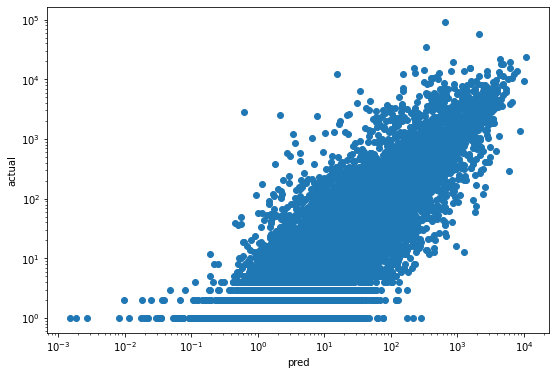

In [12]:
# checking actual vs. expected
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 6))
ax.set_xscale("log")
ax.set_yscale("log")

plt.scatter(oof_train, y_train)
plt.xlabel('pred')
plt.ylabel('actual')

Text(0, 0.5, 'actual')

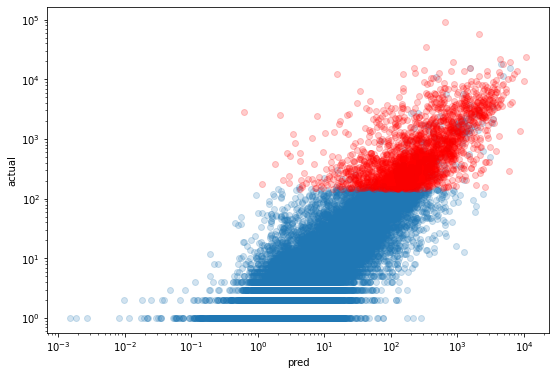

In [13]:
# checking actual vs. expected
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 6))
ax.set_xscale("log")
ax.set_yscale("log")

plt.scatter(oof_train[0:24069], y_train[0:24069], alpha=0.2)
plt.scatter(oof_train[24069:], y_train[24069:], alpha=0.2, color='red')
plt.xlabel('pred')
plt.ylabel('actual')

# 6. Submission

In [14]:
# oof
oof = pd.DataFrame()
oof[ID] = id_train
oof[TARGET] = oof_train
oof.loc[oof[TARGET]<0, TARGET] = 0
oof.to_csv(output_oof, index=False)

In [15]:
### submission
# not_in_train
sub = pd.DataFrame()
sub[ID] = id_test
sub[TARGET] = oof_test

# in_train
sub = pd.concat([sub, test_in_train[[ID, TARGET]]], axis=0)
sub = sub.sort_values(by=[ID])
sub.loc[sub[TARGET]<0, TARGET] = 0

# save
sub.to_csv(output_sub, index=False)

# ...END